# Some Importes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Explore Time Series Data

### Handling initial data file

In [2]:
df = pd.read_excel("rawdata\online_retail_II.xlsx", parse_dates=["InvoiceDate"], sheet_name=[0,1])

In [3]:
#Check number of rows and columns from the first spreadsheet "Year 2009-2010"
df[0].shape

(525461, 8)

In [4]:
#Check number of rows and columns from the second spreadsheet "Year 2010-2011"
df[1].shape

(541910, 8)

In [5]:
#Merge booth sheets into one dataframe
df_retail_data = pd.concat([df[0], df[1]])

In [6]:
#Check number of rows and columns for whole dataframe
df_retail_data.shape

(1067371, 8)

In [7]:
#See the first 5 records
df_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In the next commands we will explore the data, in order to help us to define the objective

In [8]:
# Total of products
len(df_retail_data['StockCode'].unique())

5305

In [9]:
# List of countries
df_retail_data['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [10]:
# Total of countries
len(df_retail_data['Country'].unique())

43

In [11]:
# Total of clients
len(df_retail_data['Customer ID'].unique())

5943

In [12]:
#Checking null values
df_retail_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# Feature Engineering for Time Series

In [13]:
#Manipulation
#Make the cancel invoices (Invoice starting with 'C') to be considered as negative, then all further aggregation will reflect the real amounts
df_retail_data.loc[df_retail_data['Invoice'].str.startswith('C', na=False),'Price'] *= -1

In [14]:
#Manipulation
#Create calculated column: TotalAmount = Quantity * Price
df_retail_data['TotalAmount'] = df_retail_data['Quantity'] * df_retail_data['Price']

In [15]:
#Create another dataframe indexed by the date, to do some exploratory tests with different frequencies
df_retail_data_indexed = df_retail_data[['InvoiceDate','TotalAmount']]
df_retail_data_indexed.index = df_retail_data_indexed['InvoiceDate']

In [16]:
#Monthly data
df_grouped_monthly = df_retail_data_indexed.groupby(pd.Grouper(freq='M'))

In [17]:
#Columns count - by month
df_grouped_monthly.sum()

,TotalAmount
InvoiceDate,
2009-12-31,851524.410
2010-01-31,681384.112
2010-02-28,573588.046
2010-03-31,901291.501
2010-04-30,665288.832
2010-05-31,704394.890
2010-06-30,824753.670
2010-07-31,638125.940
2010-08-31,737773.480


In [18]:
#Daily data
df_grouped_daily = df_retail_data_indexed.groupby(pd.Grouper(freq='D'))

In [19]:
#Columns count - by day
df_grouped_daily.sum()

,TotalAmount
InvoiceDate,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05
...,...
2011-12-05,119732.60
2011-12-06,59198.05
2011-12-07,75802.10


In [20]:
#Hourly data
df_grouped_hourly = df_retail_data_indexed.groupby(pd.Grouper(freq='1h'))

In [21]:
#Columns count - by hour
df_grouped_hourly.sum()

,TotalAmount
InvoiceDate,
2009-12-01 07:00:00,651.10
2009-12-01 08:00:00,0.00
2009-12-01 09:00:00,5165.23
2009-12-01 10:00:00,4921.76
2009-12-01 11:00:00,6398.01
...,...
2011-12-09 08:00:00,3581.93
2011-12-09 09:00:00,340181.21
2011-12-09 10:00:00,19888.11


# Problem Definition

The group decided to go ahead with the following time series study: **"Predict daily billing amount"**

In [22]:
#Use the data from the daily frequency as our main source
df_final_data = df_grouped_daily.sum()

## Create CSV file

In [23]:
#Check the structure
df_final_data.head()

,TotalAmount
InvoiceDate,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05


In [24]:
#Check the dataframe size
df_final_data.shape

(739, 1)

In [25]:
#Rename the 'InvoiceDate' Column to 'Date' (index) and 'TotalAmount' to 'Amount'
df_final_data=df_final_data.rename(columns = {'TotalAmount':'Amount'})
df_final_data.index.names = ['Date']

In [26]:
df_final_data.head()

,Amount
Date,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05


In [27]:
#Create CSV with daily amounts removind the days without sales (should we?)
df_final_data[df_final_data['Amount'] > 0].to_csv("./data/1-retail_daily_amount.csv")

# Data Vizualization

In [28]:
#Let's read the same file as a time series
ts_data = pd.read_csv('./data/1-retail_daily_amount.csv', index_col='Date', parse_dates=True)

In [29]:
ts_data.head()

,Amount
Date,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05


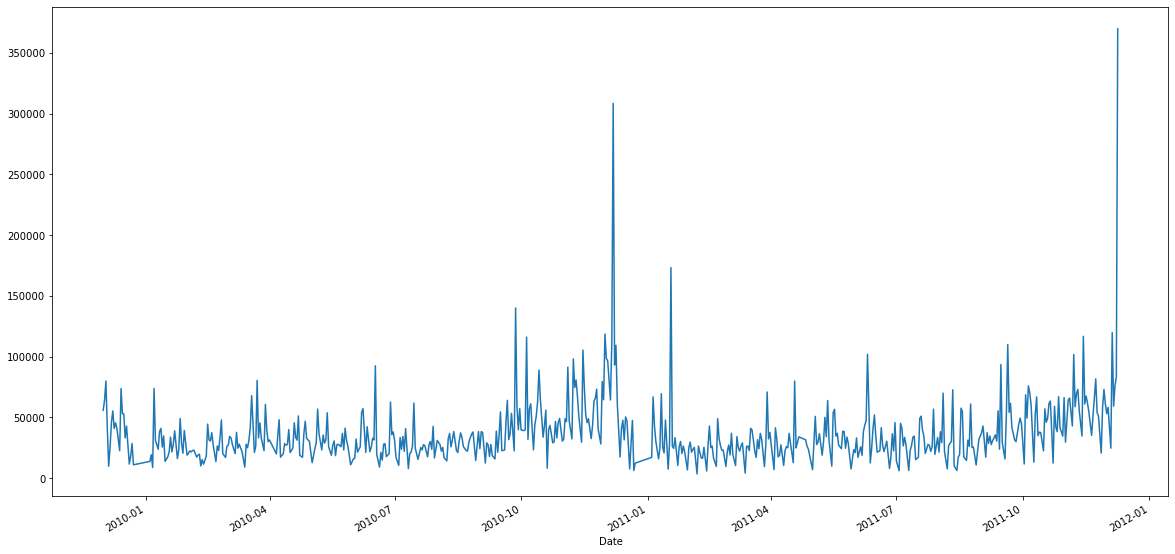

In [30]:
#Plot the time series

plt.figure(figsize=(20,10)) 
ts_data.Amount.plot().get_figure()
plt.show()

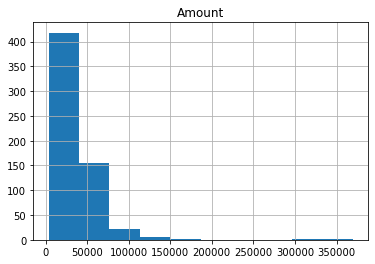

In [31]:
#Plot the histogram

ts_data.hist()
plt.show()

# Log Transform

In [32]:
#Log the Amount to make it more stable
log_data=ts_data.copy()
log_data['Amount'] = np.log(log_data['Amount'])

In [33]:
log_data.head()

,Amount
Date,
2009-12-01,10.930496
2009-12-02,11.065723
2009-12-03,11.289567
2009-12-04,10.624236
2009-12-05,9.190449


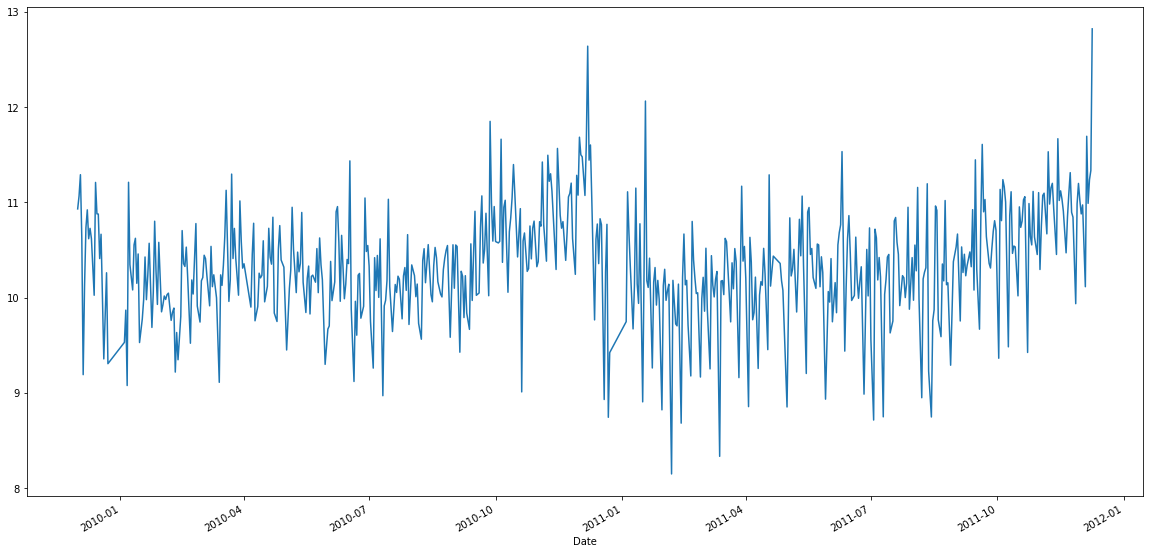

In [34]:
#Plot the time series with log
plt.figure(figsize=(20,10)) 
log_data.Amount.plot().get_figure()
plt.show()

# Moving Average and Smoothing

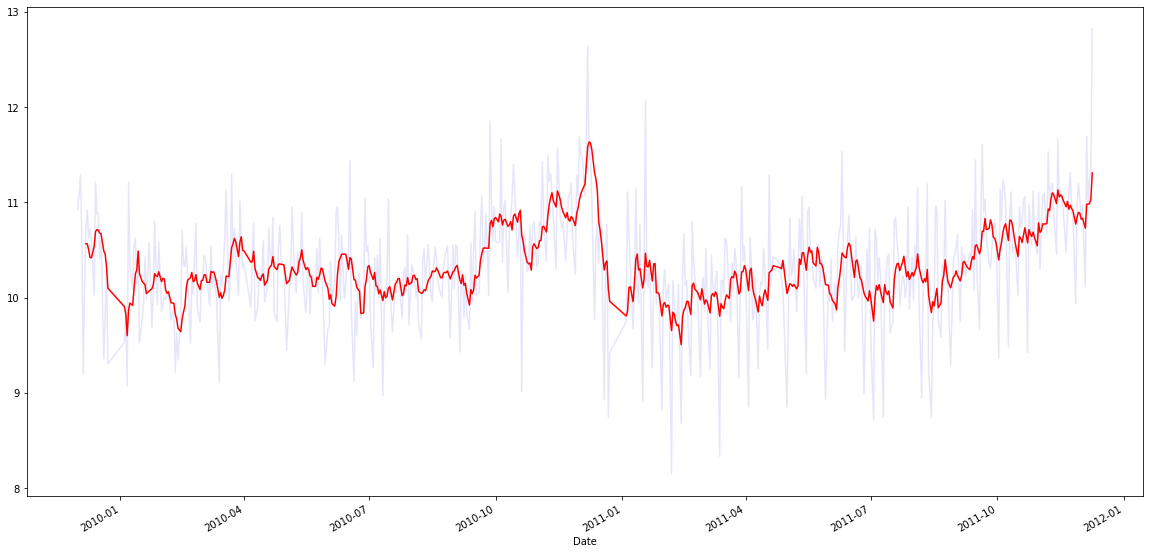

In [35]:
# Rolling - Now let's use the moving average with 7 days, to smooth the data reflecting the weekly tendency
plt.figure(figsize=(20,10)) 

log_data_roll = log_data.rolling(window=7)#7 days
log_data_r_mean = log_data_roll.mean()

log_data.Amount.plot(color='lavender')#Old data
log_data_r_mean.Amount.plot(color='red')#Moving-average data

plt.show()

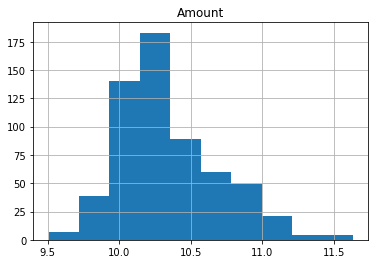

In [36]:
#Plot the histogram after log and smoothing

log_data_r_mean.hist()
plt.show()

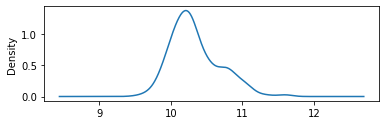

In [37]:
# density plot of time series
from pandas import read_csv
from matplotlib import pyplot
log_data_r_mean.hist()
pyplot.subplot(212)
log_data_r_mean.Amount.plot(kind='kde')
pyplot.show()

In [38]:
#Create the csv file with the adjustments
log_data_r_mean[log_data_r_mean['Amount'] > 0].to_csv("./data/2-steady_retail_daily_amount.csv")

In [39]:
#Let's read the same file as a time series
log_data_r_mean = pd.read_csv('./data/2-steady_retail_daily_amount.csv', index_col='Date', parse_dates=True)

# Decomposing Time Series

Time series decomposition is a combination of level, trend, seasonality, and noise components. Decomposition can be useful for better understanding problems during time series analysis and forecasting. 
Decomposition is used for time series analysis, and as
an analysis tool it can be used to inform forecasting models on our problem. Helps in terms of modeling complexity and specially un terms of how to capture each componete (level, trend, seasonality, and noise) in a given model. 


### Application of Additive Model

The amplitude around the trend is ore or less constant, so we are going to use the additive model.  

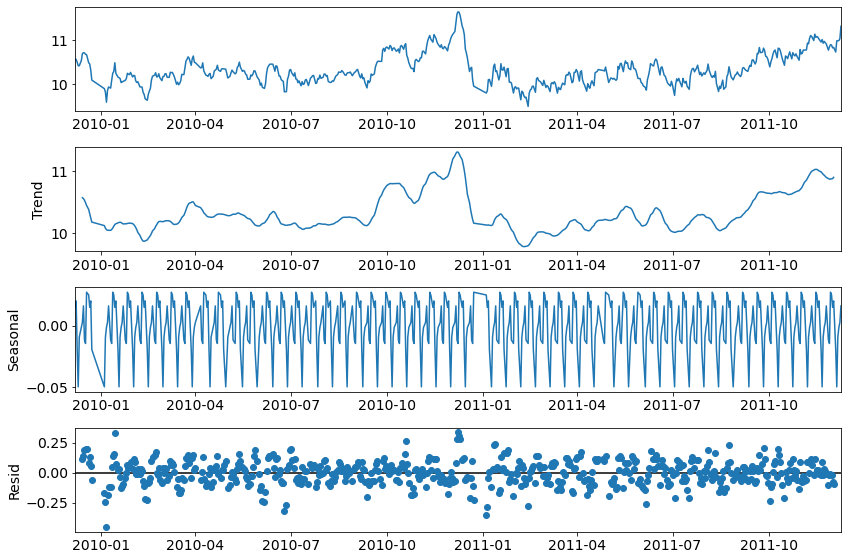

In [40]:
# components of time series

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 14})
# freq is the number of data points in a repeated cycle
result = seasonal_decompose(log_data_r_mean, model='additive',period=12)
result.plot()
plt.show()

We can verify there is some residual points after removing seasonality and trend. Is also clear that after removing trend and residual points from the time series  we have seasonality in our data. Next, we are going to analyse better our seasonality.

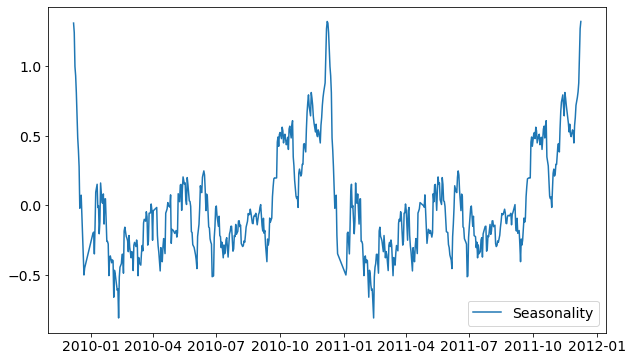

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(10,6))

decomposition = seasonal_decompose(log_data_r_mean,model='additive',period=298)
seasonal = decomposition.seasonal
#plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.show()

We can see a clear seasonality, with the sales increasing along the year until the Christmas time and decreasing abruptly just after that period.  

Observations from a non-stationary time series show seasonal efects, trends, and other structures
that depend on the time index. Summary statistics like the mean and variance do change over
time, providing a drift in the concepts a model may try to capture. Classical time series analysis
and forecasting methods are concerned with making non-stationary time series data stationary
by identifying and removing trends and removing seasonal efects.

# Stationarity - Unit root test (ADF test)

Statistical tests make strong assumptions about data. They can only be used to inform
the degree to which a null hypothesis can be rejected (or fail to be rejected). The result must
be interpreted for a given problem to be meaningful. Nevertheless, they can provide a quick
check and confrmatory evidence that time series is stationary or non-stationary.
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test1. The
intuition behind a unit root test is that it determines how strongly a time series is defined by a
trend.


Next we are going to use unit root test (Dickey-fuller test) to check if the series is stationary. We are going to verify in our original data and logarithmic data and with moving average and smoothing. 

### Original data

We are going to use the AIC criteria to let the test chose the optimal number of lags.

In [42]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(ts_data, autolag='AIC')
test1_result = pd.Series(test1[0:4], index=['ADF Test Statistic','P-Value','# Lags Used',
                                        '# Observations Used'])
print(test1_result)
print('')

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

ADF Test Statistic      -1.176208
P-Value                  0.683746
# Lags Used             17.000000
# Observations Used    584.000000
dtype: float64

We do not reject the H0: non-stationary time series <-> we have a unit root


P valeu is biger than 0.05, we don't regect the null hipostses, the null hipotisis statte that the time siries has a unit root. The serie is non stationary, the mean and variance are not constant, we are going to make the Serie stationary .

### Log data

In [43]:
from statsmodels.tsa.stattools import adfuller
test2 = adfuller(log_data_r_mean, autolag='AIC')

test2_result = pd.Series(test2[0:4], index=['ADF Test Statistic','P-Value','# Lags Used',
                                        '# Observations Used'])
print(test2_result)
print('')


if test2[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

ADF Test Statistic      -1.680529
P-Value                  0.441172
# Lags Used             19.000000
# Observations Used    576.000000
dtype: float64

We do not reject the H0: non-stationary time series <-> we have a unit root


P valeu is biger than 0.05, we don't regect the null hipostses, the null hipotisis statte that the time siries has a unit root. The serie is non stationary, the mean and variance are not constant, we are going to make the Serie stationary .

## Stationarize data: log-returns (first difference of log-values)

Time series are stationary
if they do not have trend or seasonal efects. Summary statistics calculated on the time series
are consistent over time, like the mean or the variance of the observations. When a time series
is stationary, it can be easier to model. Statistical modeling methods assume or require the
time series to be stationary to be efective.

The series is non-stationary, We are going to use some methods to try to make the series stationary. First we are going to use the first difference of the logarithms.   

In [44]:
log_returns = np.log(ts_data).diff().dropna()
log_returns.head()

,Amount
Date,
2009-12-02,0.135227
2009-12-03,0.223844
2009-12-04,-0.665330
2009-12-05,-1.433787
2009-12-06,0.932579


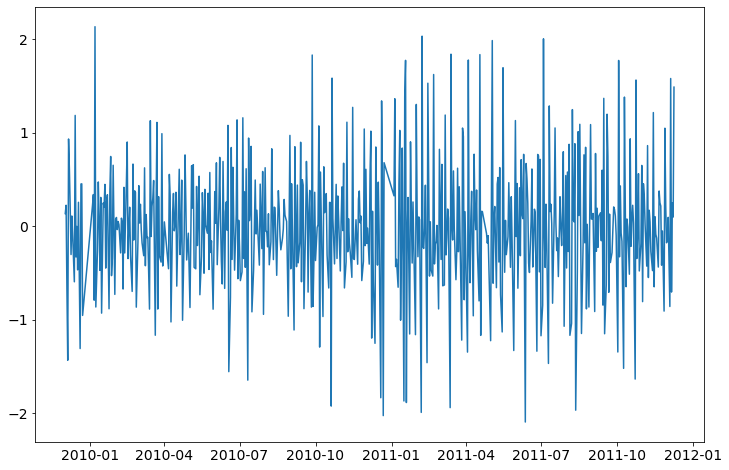

In [45]:
plt.plot(log_returns)
plt.show()

With the first difference of the logarithms we were able only to remove the trend, but the seasonality is still there. We can verify in the series that we still have repeated cycles. This repeating cycle may obscure the signal that we wish to model
when forecasting, and in turn may provide a strong signal to our predictive models.

In [46]:
## ADF unit root test
test3 = adfuller(log_returns, autolag='AIC')
test3_result = pd.Series(test3[0:4], index=['ADF Test Statistic','P-Value','# Lags Used',
                                        '# Observations Used'])
print(test3_result)
print('')
if test3[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

ADF Test Statistic    -9.091313e+00
P-Value                3.817566e-15
# Lags Used            1.600000e+01
# Observations Used    5.840000e+02
dtype: float64

We reject the H0: stationary time series <-> we don't have a unit root


P-Value is smaller than our 5% significance level, therefore we reject the null hypothesis that unit root does exist, the log_returns time series is stationary. We have an integrated stationary Serie of order 1. 

We have trend and seasonality in our original time series, to remove the trend, we are going to make the difference of order one, and to remove the seasonality we are going to make a differentiation of order 12. 

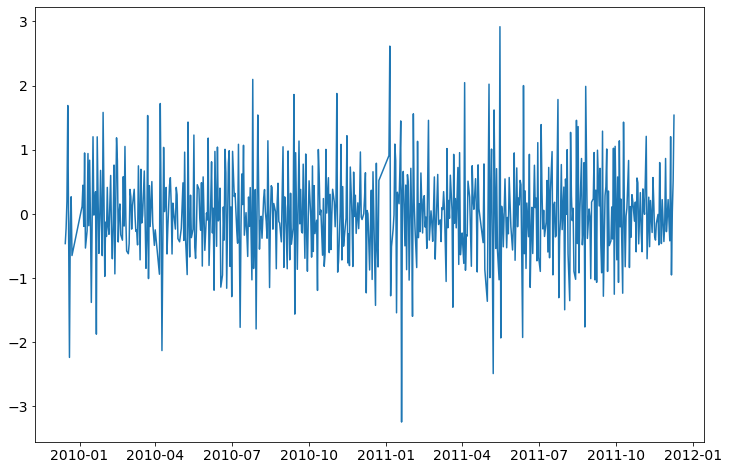

In [47]:
# Due to both trend and seasonal components, we apply one non-seasonal diff() and one seasonal differencing diff(12).
df_diff =  np.log(ts_data).diff().diff(12).dropna()
plt.plot(df_diff)
plt.show()

Now, we have the series without trend and seasonality, only with the aleatory side.  

In [48]:
#ts_data= original data
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)

## Correlogram: ACF and PACF

In [49]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

- **ACF** is an (complete) auto-correlation function which gives us values of auto-correlationof any series with its lagged values
- In simple terms, it describes how well the present valueof the series is related with its past values. 
- A time series can have components like trend,seasonality, cyclic and residual. ACF considers all these components while findingcorrelations hence it’s a ‘complete auto-correlation plot’.
- **PACF** is a partial auto-correlation function. 
- Basically instead of finding correlations ofpresent with lags like ACF, it finds correlation of the residuals (which remains afterremoving the effects which are already explained by the earlier lag(s)) with the next lagvalue hence ‘partial’ and not ‘complete’ as we remove already found variations before wefind the next correlation.
- So if there is any hidden information in the residual which canbe modeled by the next lag, we might get a good correlation and we will keep that nextlag as a feature while modeling.

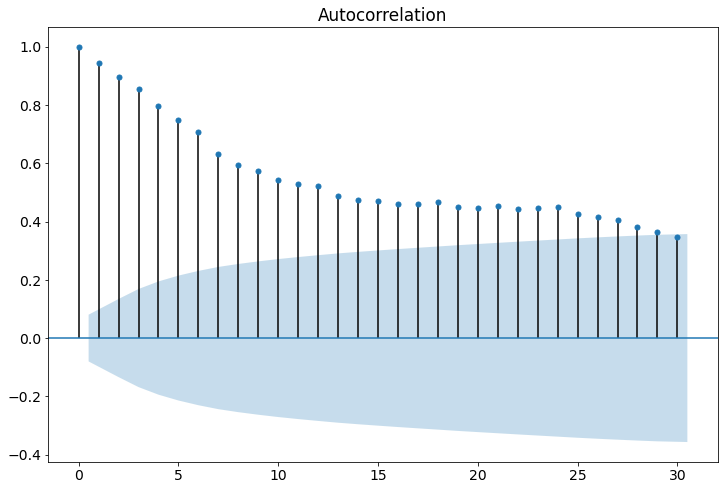

In [50]:
plot_acf(log_data_r_mean, lags=30, alpha=0.05)
plt.show()

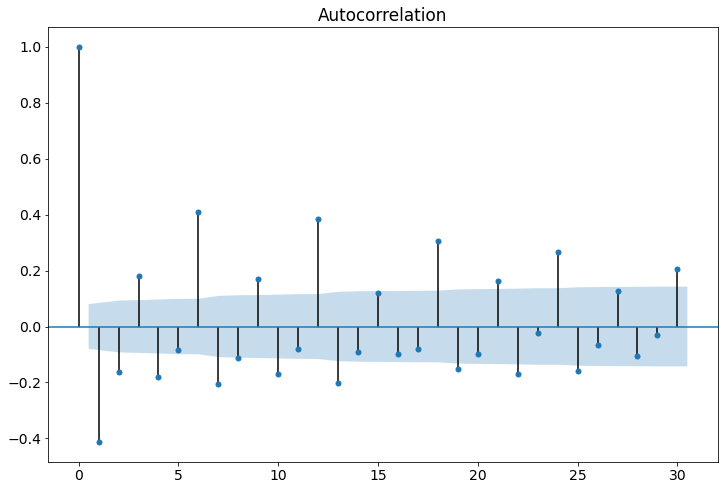

In [51]:
plot_acf(log_returns, lags=30, alpha=0.05)
plt.show()

In log-retuns data, as we verify before with Dickey-fuller test we still can se some seasonality. 

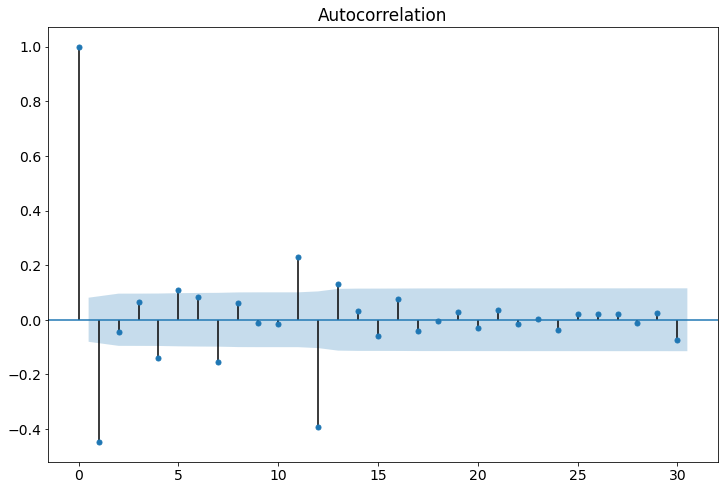

In [52]:
plot_acf(df_diff, lags=30, alpha=0.05)
plt.show()

With the difference of order one and a differentiation of order 12, we have almost white noise. We have autocorrelation 1 in the lag 0, then most correlation values are within the interval of confidence, but we still a few pics. So, we are not sure if it is only white noise, or there is still some significant correlation on the lag 1, 11 and 12.  

# ARMA / ARIMA / SARIMA Models


- The ARIMA model takes in three parameters:
    - 1. p is the order of the AR term
    - 2. q is the order of the MA term
    - 3. d is the number of differencing
    
    Seasonal ARIMA model. Here, the order argument specifies the
(p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal
component of the Seasonal ARIMA model.

In [53]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import itertools
import pmdarima as pm
warnings.filterwarnings("ignore")   ##### ignore warnings 

## Autoregressive model

Next we are going to use AR(1,0,0) model, 1 for the autoregressive side, 0 for differentiation because this series has already no trend and no seasonality and 0 for number of lags for the moving average. It is a regressive prosses of order one.

In [54]:
# Now we want to check our data with this simple ARIMA(1,0,0) model
mod1 = ARIMA(df_diff, order=(1,0,0))
result1=mod1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  589
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -605.478
Date:                Fri, 18 Jun 2021   AIC                           1216.957
Time:                        20:23:56   BIC                           1230.092
Sample:                             0   HQIC                          1222.074
                                - 589                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.019      0.120      0.904      -0.035       0.040
ar.L1         -0.4505      0.034    -13.274      0.000      -0.517      -0.384
sigma2         0.4573      0.021     21.415      0.000       0.415       0.499
===================================================================================
Ljung-Box (Q):                      229.84   Jarque-Bera (JB):                32.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.09
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

P.Valeu is bigger than 0.05 in the constant, we don’t reject the null hypothesis, H0 test the coefficient equal 0, then we can say the constant is null. In the autoregressive L1, P.Valeu is smaller than 0.05, we can say we reject the null hypothesis, the estimated coefficient is 0. W can conclude the autoregressive term of order 1 is statistically significant.

## ARIMA Model

Next, we are going to do a ARIMA (0,0,1) model, using moving average of 1 lag for the residual term. Zero for the autoregressive side, 0 for the integration side and 1 lag for moving average.

In [55]:
# Now we want to check our data with this simple ARIMA(0,0,1) model
mod2 = ARIMA(df_diff, order=(0,0,1))
result2=mod2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  589
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -549.045
Date:                Fri, 18 Jun 2021   AIC                           1104.090
Time:                        20:23:56   BIC                           1117.226
Sample:                             0   HQIC                          1109.208
                                - 589                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.006      0.198      0.843      -0.010       0.012
ma.L1         -0.7770      0.021    -36.900      0.000      -0.818      -0.736
sigma2         0.3771      0.017     21.714      0.000       0.343       0.411
===================================================================================
Ljung-Box (Q):                      173.46   Jarque-Bera (JB):                42.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.16
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again the constant is null, but we don't regect the term moving average because P.valeu is 0.

## ARMA Model

Next, we are going to do ARMA model (1,0,1), autoregressive model with moving average with 1 lag.

In [56]:
# Now we want to check our data with this simple ARIMA(1,0,1) model
mod3 = ARIMA(df_diff, order=(1,0,1))
result3=mod3.fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  589
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -535.304
Date:                Fri, 18 Jun 2021   AIC                           1078.608
Time:                        20:23:57   BIC                           1096.121
Sample:                             0   HQIC                          1085.431
                                - 589                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.854      0.393      -0.000       0.001
ar.L1          0.2386      0.032      7.527      0.000       0.176       0.301
ma.L1         -0.9999      0.708     -1.413      0.158      -2.387       0.388
sigma2         0.3571      0.253      1.414      0.157      -0.138       0.852
===================================================================================
Ljung-Box (Q):                      175.70   Jarque-Bera (JB):                28.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.06
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the comparison of information criteria, the Third model has lower AIC and HQIC, using this criteria the second model could be better.

- The final part of modelling a time series is to study the residuals.
- Ideally, the residuals will be white noise, with no autocorrelation.
- A good way to test this is to use the Ljung-Box test. Note that this test can only be applied to the residuals.
- Here, the null hypothesis for the Ljung-Box test is that there is no autocorrelation.
- White noise, by definition, is random data. A time series is white noise(random) if the variables are independent and identically distributed(i.i.d) with a mean of zero. In other words, the time series has a mean μ = 0 and a constant standard deviation σ = c.

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Ljung-Box test
acorr_ljungbox(result3.resid, lags=[2], return_df=True)

,lb_stat,lb_pvalue
2,4.221646,0.121138


We don’t reject the null, the residuals are independent.

In [58]:
# forecast one out-of-sample value
ff = result3.forecast(steps=1, alpha=0.05)
ff

589   -1.448655
dtype: float64

In [59]:
df_diff1=df_diff.copy()

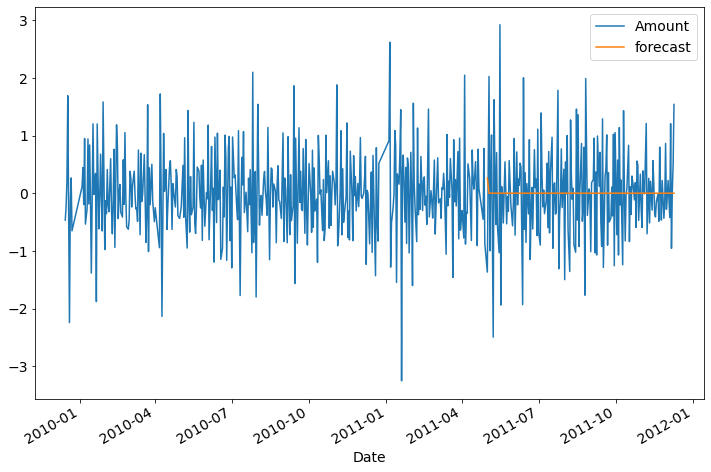

In [60]:
df_diff1['forecast']=result2.predict(start=400,end=588,dynamic=True)
df_diff1[['Amount','forecast']].plot(figsize=(12,8))

Now, the ideal would be to invert the logarithm and differentiation we did, but the model does not look exceptional, so we are going perform a Auto Arima and Sarimax model. 

# Autosarma model with original data

In [61]:
#ts_data= original data
#log_data= logarithmic data
#ts_data_r_mean=original data with smothing and moving average
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)


Now, we ar going to use original data. 

In [62]:
data=ts_data.copy()

In [63]:
# packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, kpss    ##### unit root test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm    ##### auto-arima
import warnings
warnings.filterwarnings("ignore")   ##### ignore warnings  

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 602 entries, 2009-12-01 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  602 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


<Figure size 864x576 with 0 Axes>

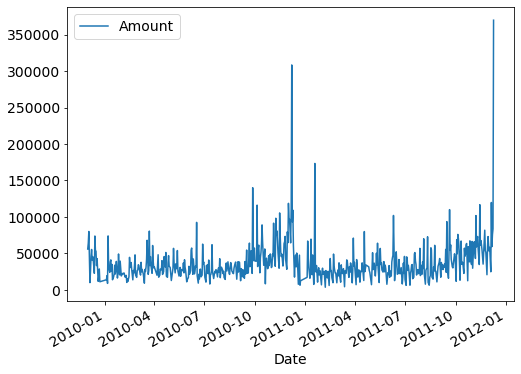

In [65]:
# plot both time series
plt.figure() 
data.plot(figsize=(8, 6))
plt.show()
# bad plot - time series with different scale

In [66]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]   
test_data = data[417:]

In [67]:
# number of observations in the test set with 'shape'
test_data.shape

(185,)

In [68]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(train_data)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

p-value = 0.000888585841622309
We reject the H0: stationary time series <-> we don't have a unit root


When we split in train and test according with D-fuller test we have a stationary time series, this situation may be due to the fact that training time series miss the last Christmas time where sales is very high.  In the next Autoarima we did try with differentiation 1 and 0, in fact we had better results with differentiation 0 when testing in test data. 

Now we are going to perform a SARMA model. We are going to star with autoregressive side p index equal to 1, moving average we are going to star in 1, maximum value for autoregressive side is 6 and for moving average is 6. M is for seasonality, we did use 12 because before we sow in the graphic that seems to be a monthly seasonality, in fact with the value 12 the model had the best performance in test data. 
In the seasonal side we did use 0 for the autoregressive side. Differentiation we did use 0, because according with D-fuller test the training series was stationary, and in fact in test the model had better results when we use differentiation 0 compared with 1. For se seasonal side we use D equal 1. 

In [69]:
# fit stepwise autoARMA with seasonality (sarma)
# we use 'auto_arima' function from pdmarima package (abreviated pm)
# best fitted model based on AIC

stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1,max_p=6, max_q=6, m=12,
start_P=0, seasonal=True,d=0, D=1, trace=True, error_action='ignore', # don't want to know if an order does not work
suppress_warnings=True, # don't want convergence warnings
stepwise=True) # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=9325.566, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9527.776, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=9387.440, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=9361.393, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9526.008, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=9467.131, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=9323.998, Time=2.47 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=9377.717, Time=0.61 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=9329.014, Time=4.40 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.25 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=9327.258, Time=2.08 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=9357.876, Time=1.98 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=9330.010, Time=5.09 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=9362.158, Time=0.67 sec
 ARIMA(1,0,0)(1,1,1)[12]

According with this package pm Arima, the best model is an Sarima. For trend side with 2 lags for the autoregressive, without differentiation and two lags in the error term for moving average. For the seasonal side we have 0 lags for autoregressive and one lag for the moving average.  

In [70]:
# best fitted model output
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  417
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -4653.660
Date:                              Fri, 18 Jun 2021   AIC                           9319.319
Time:                                      20:25:35   BIC                           9343.342
Sample:                                           0   HQIC                          9328.828
                                              - 417                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0061      0.125      0.049      0.961      -0.240       0.252
ar.L2          0.8043      0.106      7.594      0.000       0.597       1.012
ma.L1          0.2610      0.136      1.915      0.056      -0.006       0.528
ma.L2         -0.6613      0.094     -7.064      0.000      -0.845      -0.478
ma.S.L12      -0.8279      0.052    -15.923      0.000      -0.930      -0.726
sigma2      8.074e+08   1.33e-10   6.07e+18      0.000    8.07e+08    8.07e+08
===================================================================================
Ljung-Box (Q):                       52.00   Jarque-Bera (JB):             15662.10
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                             3.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.67e+34. Standard errors may be unstable.
"""

The model is an Sarimax with 417 observations, the information criteria BIC, AIC and HQIC should be as low as possible. 
Autoregressive with lag 1 and moving average with lag 1 has p.valeu bigger than 0.05, this variable are not statistically significant, don't bring contribution to the target. The situation is not the ideal, because not all variables are statistically significant, for two variables we don´t reject the hypothesis that the coefficient is null.
Residuals are independent (we do not reject Ljung-Box H0: residuals are independent), there is no serial correlation. 
Residuals are heteroskedastic or variance is not constant (we reject H0: variance is constant).
Residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution).

Only the first presupposition of residual independency is verified but is enough to make the prevision.  

Now let’s check the performance of the model in the test dataset, for unknown values. We are going to make a prevision on the test dataset. 

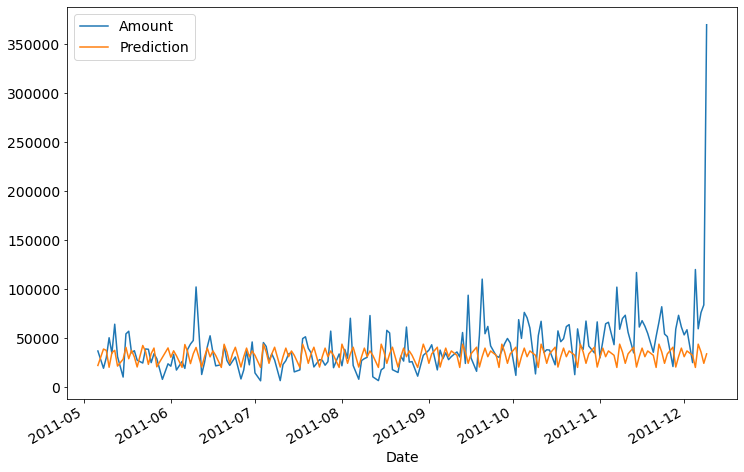

In [71]:
# since residuals are independent -> Box_Jenkins -> we can do some forecast
# forecast (out-of-sample) 185 future values by using best fitted model on the train set

future_forecast = stepwise_fit.predict(n_periods=len(test_data))

# join the forecasted value and the test_data values in the same dataframe and plot both

future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,future_forecast],axis=1).plot()
plt.show()

We can see that the model had reasonable  performance until Christmas time time, but was not able to predict the Christmas time sales period in a efficient way. 

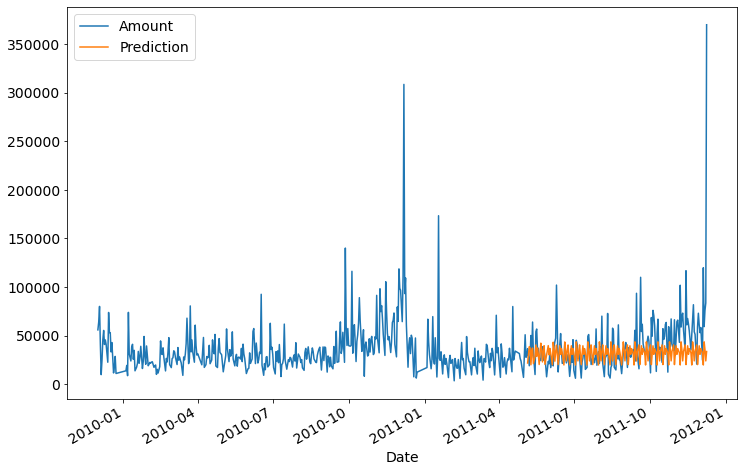

In [72]:
# plot original gdp time series and the forecast (last 185 values)
pd.concat([data,future_forecast],axis=1).plot()

In [73]:
# forecast performance metrics
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=185, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"SMAPE: {smape(test_data, forecasts)}")

Mean squared error: 1210538148.3584573
SMAPE: 47.77302624893639


In [74]:
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - forecasts) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the forecast is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast is 51.00%


We can see that the mean absolute percentage error for the forecast is high. We did try different configurations of parameters in the model and different ways to split the train and test data, but the performance was not god in any of them. So, we are going to try different models, we are going to use the log returns data for the next model. 

# Autosarima model with log returns data (first difference)

In [75]:
#ts_data= original data
#ts_data_r_mean=original data with smothing and moving average
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)


Now, we ar going to use log returns data with the first difference.

In [76]:
data=log_returns.copy()

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 601 entries, 2009-12-02 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  601 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


<Figure size 864x576 with 0 Axes>

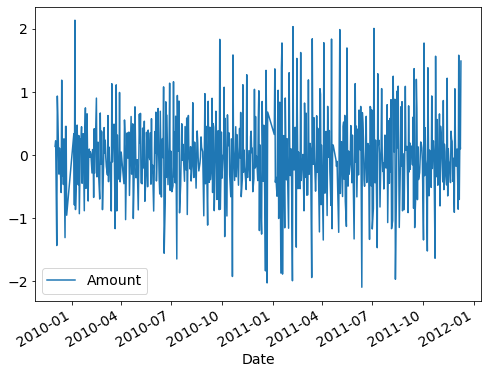

In [78]:
# plot both time series
plt.figure() 
data.plot(figsize=(8, 6))
plt.show()
# bad plot - time series with different scale

In [79]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]   
test_data = data[417:]

In [80]:
# number of observations in the test set with 'shape'
test_data.shape

(184,)

In [81]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(train_data)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

p-value = 2.7952010049313816e-12
We reject the H0: stationary time series <-> we don't have a unit root


When we split in train and test according with D-fuller test we have a stationary time series, this situation may be due to the fact that training time series miss the last Christmas time where sales is very high.  In the next Autoarima we did try with differentiation 1 and 0, in fact we had better results with differentiation 0 when testing in test data. 

Now we are going to perform a SARIMA model. We are going to start with autoregressive side p index equal to 1, moving average we are going to star in 1, maximum value for autoregressive side is 6 and for moving average is 6. M is for seasonality, we did use 12 because before we sow in the graphic that seems to be a monthly seasonality, in fact with the value 12 the model had the best performance in test data. 
In the seasonal side we did use 0 for the autoregressive side. Differentiation we did use 0, because according with D-fuller test the training series was stationary, and in fact in test the model had better results when we use differentiation 0 compared with 1. For se seasonal side we use D equal 1. 

In [82]:
# fit stepwise autoARIMA with seasonality (sarima)
# we use 'auto_arima' function from pdmarima package (abreviated pm)
# best fitted model based on AIC

stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1,max_p=6, max_q=6, m=12,
start_P=0, seasonal=True,d=0, D=1, trace=True, error_action='ignore', # don't want to know if an order does not work
suppress_warnings=True, # don't want convergence warnings
stepwise=True) # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=616.138, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=907.580, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=769.227, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=621.846, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=905.583, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=616.200, Time=3.11 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=616.442, Time=11.50 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=674.237, Time=2.10 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=619.395, Time=5.77 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=715.722, Time=0.78 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=617.971, Time=2.39 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=616.577, Time=4.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=783.621, Time=0.46 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept  

According with this package pm Arima, the best model is an Sarima. For trend side with 0 lags for the autoregressive, without differentiation and two lags in the error term for moving average. For the seasonal side we have 0 lags for autoregressive and one lag for the moving average.  

In [83]:
# best fitted model output
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  417
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -302.954
Date:                              Fri, 18 Jun 2021   AIC                            613.908
Time:                                      20:26:57   BIC                            629.924
Sample:                                           0   HQIC                           620.248
                                              - 417                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7171      0.049    -14.688      0.000      -0.813      -0.621
ma.L2         -0.1521      0.048     -3.200      0.001      -0.245      -0.059
ma.S.L12      -0.7756      0.035    -22.257      0.000      -0.844      -0.707
sigma2         0.2533      0.013     19.467      0.000       0.228       0.279
===================================================================================
Ljung-Box (Q):                       56.02   Jarque-Bera (JB):                59.56
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model is an Sarimax with 417 observations, the information criteria BIC, AIC and HQIC should be as low as possible. 
All variables are statisticaly significant.
Residuals are independent (we do not reject Ljung-Box H0: residuals are independent), there is no serial correlation. 
Residuals are heteroskedastic or variance is not constant (we reject H0: variance is constant).
Residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution).

Only the first presupposition of residual independency is verified but is enough to make the prevision.  

Now let’s check the performance of the model in the test dataset, for unknown values. We are going to make a prevision on the test dataset. 

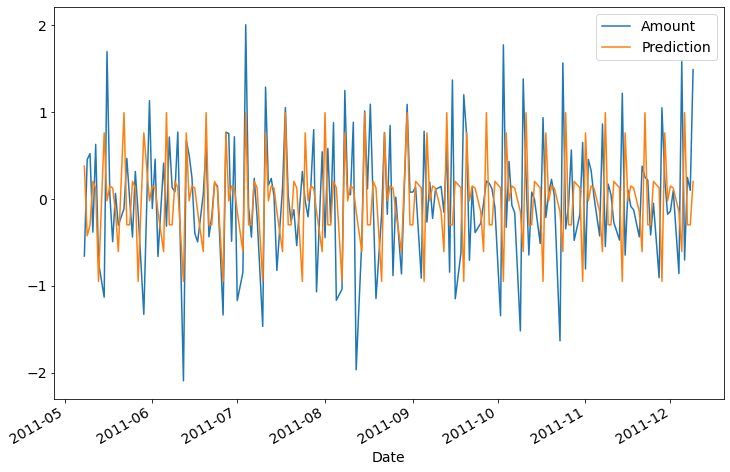

In [84]:
# since residuals are independent -> Box_Jenkins -> we can do some forecast
# forecast (out-of-sample) 184 future values by using best fitted model on the train set

future_forecast = stepwise_fit.predict(n_periods=len(test_data))

# join the forecasted value and the test_data values in the same dataframe and plot both

future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,future_forecast],axis=1).plot()
plt.show()

Removing the trend, we can see that our model has etter performance. 

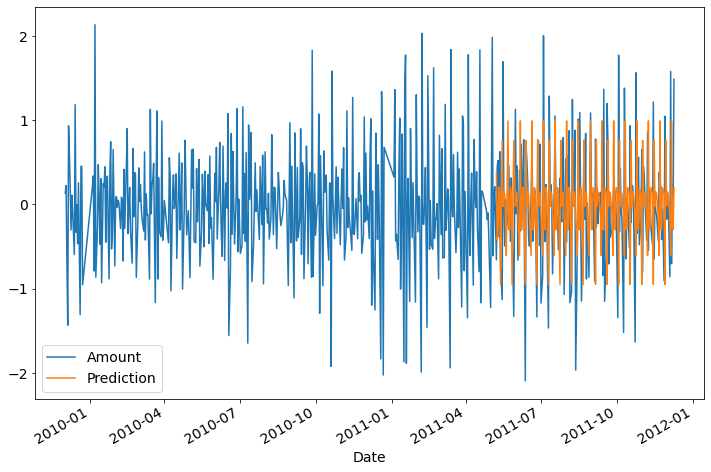

In [85]:
# plot original gdp time series and the forecast (last 185 values)
pd.concat([data,future_forecast],axis=1).plot()

In [86]:
# forecast performance metrics
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=184, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"SMAPE: {smape(test_data, forecasts)}")

Mean squared error: 0.7540874713079231
SMAPE: 146.8411585510443


In [87]:
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - forecasts) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the forecast is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast is 232.20%


Visual our model looks better but,  we can see that the mean absolute percentage error for the forecast is Worst than the previous model . So, we are going to try different models, we are going to use the differentiation of order 12 data for the next model. 

# Autosarima model with log returns and differentiation of order 12

In [88]:
#ts_data= original data
#ts_data_r_mean=original data with smothing and moving average
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)


Now, we ar going to use the data data with log returns and differentiation of order 12.

In [89]:
data=df_diff.copy()

In [127]:
df_diff

,Amount
Date,
2009-12-15,-0.464886
2009-12-16,-0.226496
2009-12-17,0.198244
2009-12-18,1.689066
2009-12-20,-2.241155
...,...
2011-12-05,1.202997
2011-12-06,-0.954226
2011-12-07,0.031563


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 589 entries, 2009-12-15 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  589 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


<Figure size 864x576 with 0 Axes>

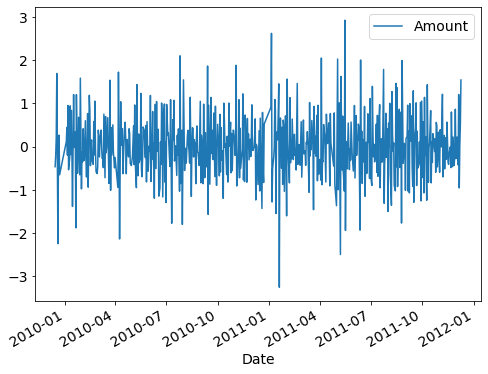

In [91]:
# plot both time series
plt.figure() 
data.plot(figsize=(8, 6))
plt.show()
# bad plot - time series with different scale

In [92]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]   
test_data = data[417:]

In [93]:
# number of observations in the test set with 'shape'
test_data.shape

(172,)

In [94]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(train_data)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

p-value = 2.07132546154101e-18
We reject the H0: stationary time series <-> we don't have a unit root


When we split in train and test according with D-fuller test we have a stationary time series, this situation may be due to the fact that training time series miss the last Christmas time where sales is very high.  In the next Autoarima we did try with differentiation 1 and 0, in fact we had better results with differentiation 0 when testing in test data. 

Now we are going to perform a SARIMA model. We are going to star with autoregressive side p index equal to 1, moving average we are going to star in 1, maximum value for autoregressive side is 6 and for moving average is 6. M is for seasonality, we did use 12 because before we sow in the graphic that seems to be a monthly seasonality, in fact with the value 12 the model had the best performance in test data. 
In the seasonal side we did use 0 for the autoregressive side. Differentiation we did use 0, because Because the data has already a differentiation of order 12.

In [95]:
# fit stepwise autoARIMA with seasonality (sarima)
# we use 'auto_arima' function from pdmarima package (abreviated pm)
# best fitted model based on AIC

stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1,max_p=6, max_q=6, m=12,
start_P=0, seasonal=True,d=0, D=1, trace=True, error_action='ignore', # don't want to know if an order does not work
suppress_warnings=True, # don't want convergence warnings
stepwise=True) # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1341.682, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1074.965, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1339.684, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1268.213, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=985.932, Time=2.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=19.45 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1069.045, Time=2.09 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=939.200, Time=2.52 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1032.857, Time=0.88 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=16.86 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=936.92

According with this package pm Arima, the best model is an Sarima. For trend side with 5 lags for the autoregressive, without differentiation and 0 lags in the error term for moving average. For the seasonal side we have 2 lags for autoregressive and 1 lag for the moving average.  

In [96]:
# best fitted model output
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  417
Model:             SARIMAX(5, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -441.213
Date:                            Fri, 18 Jun 2021   AIC                            898.427
Time:                                    20:32:23   BIC                            930.458
Sample:                                         0   HQIC                           911.105
                                            - 417                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6927      0.050    -13.876      0.000      -0.791      -0.595
ar.L2         -0.5503      0.062     -8.909      0.000      -0.671      -0.429
ar.L3         -0.3603      0.065     -5.510      0.000      -0.488      -0.232
ar.L4         -0.3776      0.064     -5.940      0.000      -0.502      -0.253
ar.L5         -0.1784      0.054     -3.301      0.001      -0.284      -0.072
ar.S.L12      -0.9820      0.040    -24.723      0.000      -1.060      -0.904
ar.S.L24      -0.4802      0.042    -11.569      0.000      -0.562      -0.399
sigma2         0.4997      0.029     17.471      0.000       0.444       0.556
===================================================================================
Ljung-Box (Q):                       91.12   Jarque-Bera (JB):                34.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.16
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model is an Sarimax with 417 observations, the information criteria BIC, AIC and HQIC should be as low as possible. 
All variables are statisticaly significant.
Residuals are independent (we do not reject Ljung-Box H0: residuals are independent), there is no serial correlation. 
Residuals are heteroskedastic or variance is not constant (we reject H0: variance is constant).
Residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution).

Only the first presupposition of residual independency is verified but is enough to make the prevision.  

Now let’s check the performance of the model in the test dataset, for unknown values. We are going to make a prevision on the test dataset. 

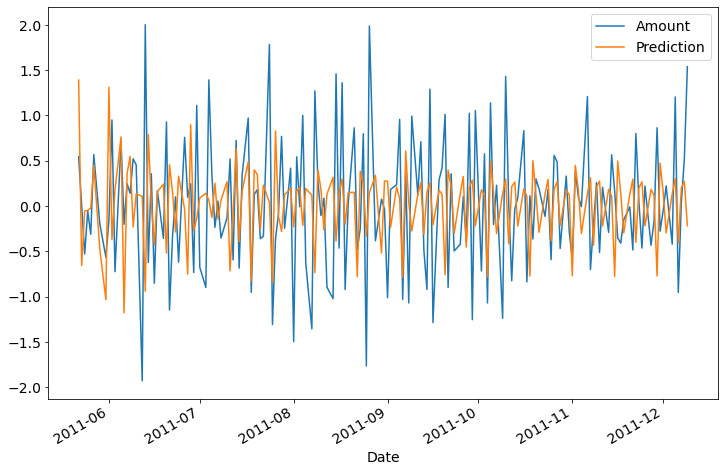

In [97]:
# since residuals are independent -> Box_Jenkins -> we can do some forecast
# forecast (out-of-sample) 184 future values by using best fitted model on the train set

future_forecast = stepwise_fit.predict(n_periods=len(test_data))

# join the forecasted value and the test_data values in the same dataframe and plot both

future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,future_forecast],axis=1).plot()
plt.show()

Removing the trend, we can see that our model has simmilar performace with the last one. Let’s check the performance measures. 

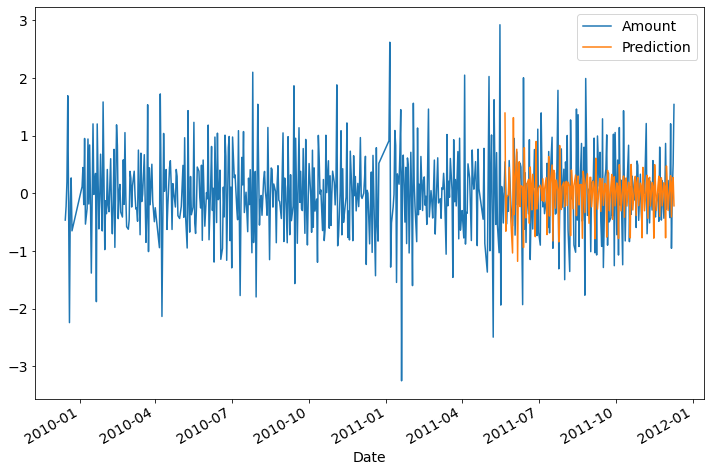

In [98]:
# plot original gdp time series and the forecast (last 185 values)
pd.concat([data,future_forecast],axis=1).plot()

In [99]:
# forecast performance metrics
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=172, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"SMAPE: {smape(test_data, forecasts)}")

Mean squared error: 0.6904685490572067
SMAPE: 144.5494963960515


In [100]:
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - forecasts) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the forecast is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast is 232.49%


We can see that the mean absolute percentage error for the forecast is almost the same compared with le last one.

# Autosarima model with Smoothing and moving average data 

In [101]:
#ts_data= original data
#ts_data_r_mean=original data with smothing and moving average
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)


Now, we ar going to use the data data with Smoothing and moving average dat. 

In [102]:
data=np.exp(log_data_r_mean)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2009-12-07 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  596 non-null    float64
dtypes: float64(1)
memory usage: 9.3 KB


<Figure size 864x576 with 0 Axes>

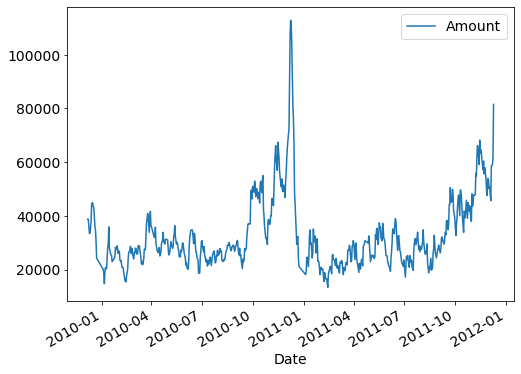

In [104]:
# plot both time series
plt.figure() 
data.plot(figsize=(8, 6))
plt.show()
# bad plot - time series with different scale

In [105]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]   
test_data = data[417:]

In [106]:
# number of observations in the test set with 'shape'
test_data.shape

(179,)

In [107]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(train_data)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

p-value = 0.2291726674099816
We do not reject the H0: non-stationary time series <-> we have a unit root


When we split in train and test according with D-fuller test we have a stationary time series, this situation may be due to the fact that training time series miss the last Christmas time where sales is very high.  In the next Autoarima we did try with differentiation 1 and 0, in fact we had better results with differentiation 0 when testing in test data. 

Now we are going to perform a SARIMA model. We are going to star with autoregressive side p index equal to 1, moving average we are going to star in 1, maximum value for autoregressive side is 12 and for moving average is 12. M is for seasonality, we did use 12 because before we sow in the graphic that seems to be a monthly seasonality, in fact with the value 12 the model had the best performance in test data. 
In the seasonal side we did use 0 for the autoregressive side. Differentiation we did use 1.

In [108]:
# fit stepwise autoARIMA with seasonality (sarima)
# we use 'auto_arima' function from pdmarima package (abreviated pm)
# best fitted model based on AIC

stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1,max_p=12, max_q=12, m=12,
start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', # don't want to know if an order does not work
suppress_warnings=True, # don't want convergence warnings
stepwise=True) # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=7759.166, Time=1.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8008.999, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7825.257, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=7765.177, Time=1.38 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=7921.898, Time=0.26 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=7761.056, Time=3.23 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=7761.075, Time=7.38 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=7825.844, Time=0.73 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=9.64 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=7760.241, Time=1.20 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=7789.939, Time=1.26 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=7760.847, Time=2.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=7797.166, Time=0.99 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=7765.356, Time=3.14 sec
 ARIMA(2,1,0)(0,1,1)[12]

According with this package pm Arima, the best model is an Sarima. For trend side with 1 lags for the autoregressive, differentiation 1 and 1 lags in the error term for moving average. For the seasonal side we have 0 lags for autoregressive and 1 lag for the moving average.  

In [109]:
# best fitted model output
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  417
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3875.583
Date:                            Fri, 18 Jun 2021   AIC                           7759.166
Time:                                    20:33:05   BIC                           7775.172
Sample:                                         0   HQIC                          7765.502
                                            - 417                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5695      0.081      6.991      0.000       0.410       0.729
ma.L1         -0.2995      0.107     -2.811      0.005      -0.508      -0.091
ma.S.L12      -0.7334      0.031    -23.497      0.000      -0.795      -0.672
sigma2      1.239e+07   5.84e+05     21.203      0.000    1.12e+07    1.35e+07
===================================================================================
Ljung-Box (Q):                      120.15   Jarque-Bera (JB):               217.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model is an Sarimax with 417 observations, the information criteria BIC, AIC and HQIC should be as low as possible. 
All variables are statisticaly significant.
Residuals are independent (we do not reject Ljung-Box H0: residuals are independent), there is no serial correlation. 
Residuals are heteroskedastic or variance is not constant (we reject H0: variance is constant).
Residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution).

Only the first presupposition of residual independency is verified but is enough to make the prevision.  

Now let’s check the performance of the model in the test dataset, for unknown values. We are going to make a prevision on the test dataset. 

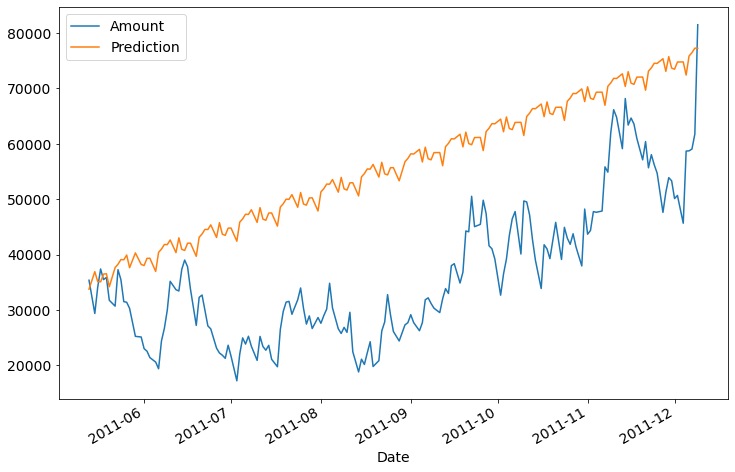

In [110]:
# since residuals are independent -> Box_Jenkins -> we can do some forecast
# forecast (out-of-sample) 184 future values by using best fitted model on the train set

future_forecast = stepwise_fit.predict(n_periods=len(test_data))

# join the forecasted value and the test_data values in the same dataframe and plot both

future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,future_forecast],axis=1).plot()
plt.show()

Removing the trend, we can see that our model has simmilar performace with the last one. Let’s check the performance measures. 

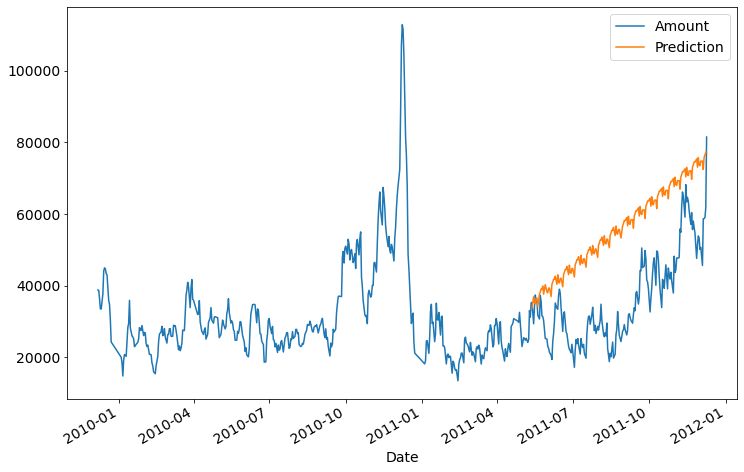

In [111]:
# plot original gdp time series and the forecast (last 185 values)
pd.concat([data,future_forecast],axis=1).plot()

This model was able to predict the increase of Christmas sales, but did it in a linear away, was not able to predict all the patron of the data. 

In [112]:
# forecast performance metrics
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=179, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"SMAPE: {smape(test_data, forecasts)}")

Mean squared error: 448893617.6832802
SMAPE: 44.68420048999034


In [113]:
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - forecasts) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the forecast is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast is 62.90%


We can see that the mean absolute percentage error for the forecast is smaler, But is still hight, lets try to make another model with different configurations, we are going to use differentiation 0 in the AutoSarma  parameter.

# Autosarma model with Smoothing and moving average data: d=0

In [114]:
#ts_data= original data
#ts_data_r_mean=original data with smothing and moving average
#log_data_r_mean = log data with Moving Average and Smoothing 
#log_returns = log and returns (no trend but has seasonality)
#Df_diff = (no trend and no seasonality)


Now, we ar going to use the data data with Smoothing and moving average data.

In [115]:
data=np.exp(log_data_r_mean)

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2009-12-07 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  596 non-null    float64
dtypes: float64(1)
memory usage: 9.3 KB


<Figure size 864x576 with 0 Axes>

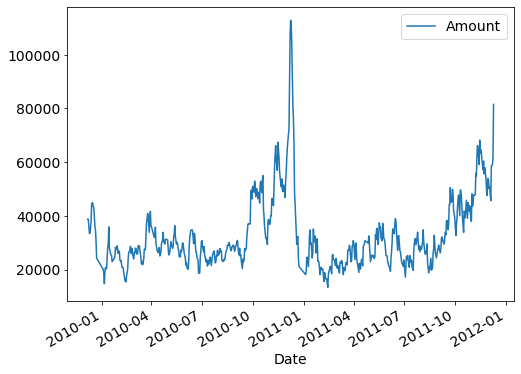

In [117]:
# plot both time series
plt.figure() 
data.plot(figsize=(8, 6))
plt.show()
# bad plot - time series with different scale

In [118]:
# Create Training and Test
data=data['Amount']

train_data = data[:417]   
test_data = data[417:]

In [119]:
# number of observations in the test set with 'shape'
test_data.shape

(179,)

In [120]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(train_data)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
else:
    print("We reject the H0: stationary time series <-> we don't have a unit root")

p-value = 0.2291726674099816
We do not reject the H0: non-stationary time series <-> we have a unit root


When we split in train and test according with D-fuller test we have a stationary time series, this situation may be due to the fact that training time series miss the last Christmas time where sales is very high.  In the next Autoarima we did try with differentiation 1 and 0, in fact we had better results with differentiation 0 when testing in test data. 

Now we are going to perform a SARMA model. We are going to star with autoregressive side p index equal to 1, moving average we are going to star in 1, maximum value for autoregressive side is 12 and for moving average is 12. M is for seasonality, we did use 12 because before we sow in the graphic that seems to be a monthly seasonality, in fact with the value 12 the model had the best performance in test data. 
In the seasonal side we did use 0 for the autoregressive side. Differentiation we did use 0.

In [121]:
# fit stepwise autoARIMA with seasonality (sarima)
# we use 'auto_arima' function from pdmarima package (abreviated pm)
# best fitted model based on AIC

stepwise_fit = pm.auto_arima(train_data, start_p=1, start_q=1,max_p=12, max_q=12, m=12,
start_P=0, seasonal=True,d=0, D=1, trace=True, error_action='ignore', # don't want to know if an order does not work
suppress_warnings=True, # don't want convergence warnings
stepwise=True) # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=7835.980, Time=3.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8948.478, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7917.027, Time=1.99 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=8396.423, Time=2.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8946.864, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=8001.796, Time=0.27 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=7833.918, Time=4.17 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=7871.581, Time=2.62 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=7832.833, Time=14.93 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=7874.818, Time=3.04 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=7860.424, Time=7.67 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=7833.101, Time=12.26 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=9.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=7859.329, Time=13.83 sec
 ARIMA(2,0,1)(2,1,1)[

According with this package pm Arima, the best model is an Sarima. For trend side with 0 lags for the autoregressive, differentiation 0 and 0 lags in the error term for moving average. For the seasonal side we have 2 lags for autoregressive and 1 lag for the moving average.  

In [122]:
# best fitted model output
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  417
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -3906.813
Date:                              Fri, 18 Jun 2021   AIC                           7825.626
Time:                                      20:37:16   BIC                           7849.650
Sample:                                           0   HQIC                          7835.135
                                              - 417                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2256      0.038     32.579      0.000       1.152       1.299
ar.L2         -0.2974      0.040     -7.464      0.000      -0.375      -0.219
ar.S.L12       0.0018      0.070      0.026      0.979      -0.136       0.140
ar.S.L24       0.1665      0.060      2.766      0.006       0.049       0.284
ma.S.L12      -0.7970      0.060    -13.297      0.000      -0.915      -0.680
sigma2      1.361e+07   2.26e-09   6.02e+15      0.000    1.36e+07    1.36e+07
===================================================================================
Ljung-Box (Q):                       89.77   Jarque-Bera (JB):               638.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.69
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.06e+31. Standard errors may be unstable.
"""

The model is an Sarimax with 417 observations, the information criteria BIC, AIC and HQIC should be as low as possible. 
Not all variables are statisticaly significant.
Residuals are independent (we do not reject Ljung-Box H0: residuals are independent), there is no serial correlation. 
Residuals are heteroskedastic or variance is not constant (we reject H0: variance is constant).
Residuals are not Gaussian (we reject Jarque-Bera H0: normal distribution).

Only the first presupposition of residual independency is verified but is enough to make the prevision.  

Now let’s check the performance of the model in the test dataset, for unknown values. We are going to make a prevision on the test dataset. 

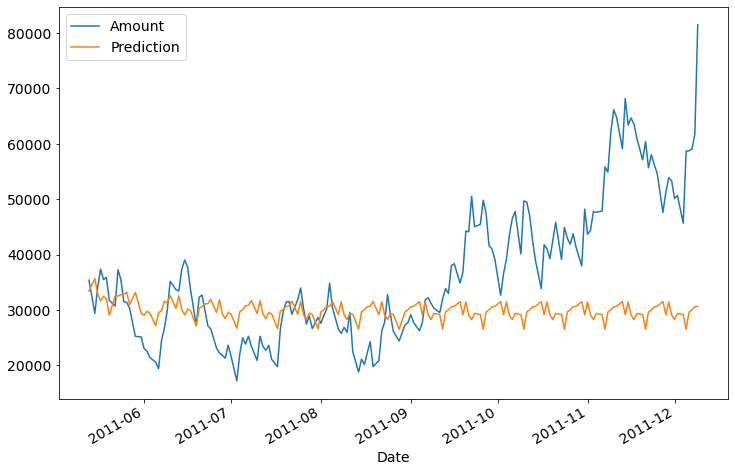

In [123]:
# since residuals are independent -> Box_Jenkins -> we can do some forecast
# forecast (out-of-sample) 184 future values by using best fitted model on the train set

future_forecast = stepwise_fit.predict(n_periods=len(test_data))

# join the forecasted value and the test_data values in the same dataframe and plot both

future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,future_forecast],axis=1).plot()
plt.show()

Removing the trend, we can see that our model has simmilar performace with the last one. Let’s check the performance measures. 

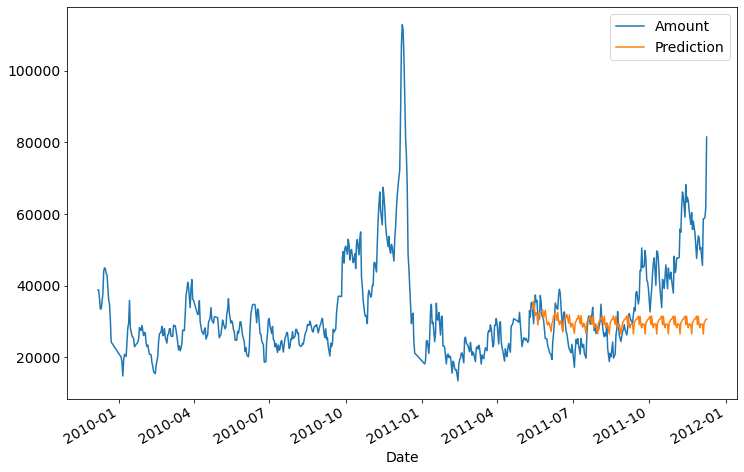

In [124]:
# plot original gdp time series and the forecast (last 185 values)
pd.concat([data,future_forecast],axis=1).plot()

In [125]:
# forecast performance metrics
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=179, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
print(f"SMAPE: {smape(test_data, forecasts)}")

Mean squared error: 209696852.54083487
SMAPE: 28.51726492048549


In [126]:
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data.values - forecasts) / test_data.values)) * 100

print('The Mean Absolute Percentage Error for the forecast is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast is 25.40%


We can see that the mean absolute percentage error for the forecast is better, but cannot predict the trend neither seasonality, so we have to try to find a better model. 